# Modelling and Analysis of Puffin Data 

Packages used in this data analysis:

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from pandas import DataFrame
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Read in the CSV file containing the puffin data, and view information about the data.

In [2]:
puffins = pd.read_csv("puffins.csv")


print(puffins.info()) #check data types 
print(puffins.describe()) #describe numerical data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   body_mass_kg    341 non-null    float64
 1   wing_length_m   342 non-null    float64
 2   beak_length_mm  341 non-null    float64
 3   beak_depth_mm   342 non-null    float64
 4   species         344 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None
       body_mass_kg  wing_length_m  beak_length_mm  beak_depth_mm
count    341.000000     342.000000      341.000000     342.000000
mean       1.695413       0.194816       45.263516      17.837216
std        0.322047       0.013686        5.614171       2.053785
min        1.091000       0.167000       33.063000      13.624000
25%        1.434000       0.184000       40.479000      16.224000
50%        1.636000       0.191000       45.835000      17.992000
75%        1.919000       0.207000       49.955000      19.44

From this quick overview we can see the data is mostly clear without outliers. The data type for each column is as it should be.

In [3]:
species_counts = puffins["species"].value_counts()
print(species_counts)

species
Arctica        152
Corniculata    124
Cirrhata        68
Name: count, dtype: int64


There is a significant imbalance in the class weightings, as there is far less data on the Cirrhata species. This could affect bias towards Arctica or Corniculata which have higher weightings.

In [4]:
display(puffins)
puffins.isnull().values.any() #check for NA values in the data

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,1.384,0.181,39.243,18.304,Arctica
1,1.717,0.189,44.084,19.240,Arctica
2,1.717,0.184,40.376,19.344,Arctica
3,1.414,0.187,37.904,19.240,Arctica
4,1.273,0.177,37.595,18.720,Arctica
...,...,...,...,...,...
339,1.879,0.207,44.805,15.808,Corniculata
340,1.697,0.202,46.659,14.352,Corniculata
341,2.283,0.224,55.929,16.328,Corniculata
342,2.343,0.223,50.058,16.640,Corniculata


True

### Cleaning the data

In [5]:
na_rows = puffins[puffins.isnull().any(axis=1)] #create dataframe including only rows that contain NAs
na_rows

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
11,NaN,NaN,NaN,NaN,Arctica
44,1.252,0.180,NaN,19.240,Arctica
241,NaN,NaN,NaN,NaN,Corniculata
264,NaN,0.213,52.633,16.952,Corniculata


In [6]:
#drop the NA rows from the data and create new dataframe with no NAs
puffins.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
puffins_new = puffins.dropna()
print(puffins_new.isnull().values.any()) #check the NAs have been removed 


False


In [7]:
#make sure the measurements are uniform units

#convert 'wing_length_m' to millimeters and create a new column 'wing_length_mm'
puffins_new["wing_length_mm"] = puffins_new["wing_length_m"] * 1000

#drop the original 'wing_length_m' column and assign the modified DataFrame back to puffins_new
puffins_new = puffins_new.drop(columns=["wing_length_m"])

# puffins_new has changed data heading
puffins_new

C:\Users\magba\AppData\Local\Temp\ipykernel_26292\1432890054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puffins_new["wing_length_mm"] = puffins_new["wing_length_m"] * 1000


,body_mass_kg,beak_length_mm,beak_depth_mm,species,wing_length_mm
0,1.384,39.243,18.304,Arctica,181.0
1,1.717,44.084,19.240,Arctica,189.0
2,1.717,40.376,19.344,Arctica,184.0
3,1.414,37.904,19.240,Arctica,187.0
4,1.273,37.595,18.720,Arctica,177.0
...,...,...,...,...,...
339,1.879,44.805,15.808,Corniculata,207.0
340,1.697,46.659,14.352,Corniculata,202.0
341,2.283,55.929,16.328,Corniculata,224.0
342,2.343,50.058,16.640,Corniculata,223.0


### Visualising the data

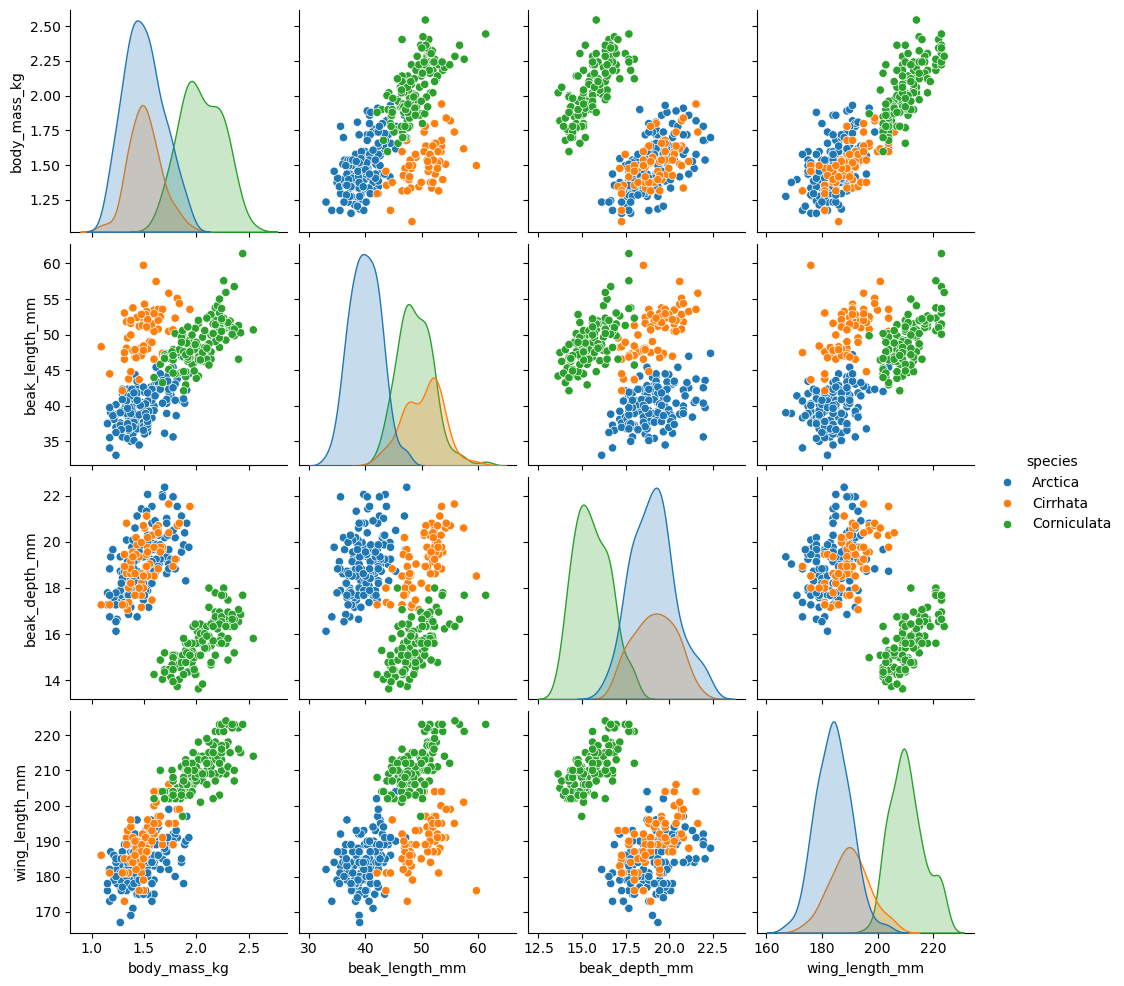

In [8]:
#create a set of pairwise plots between all data points 
sns.pairplot(puffins_new, hue="species")
plt.show()

From these pairwise charts, we can determine how to analyse the trends. With distinct classes, we can achieve a well- modelled k-nearest neighbours (KNN) analysis.

The pairs to consider here are:

- beak_length_mm / wing_length_mm
- beak_length_mm / beak_depth_mm 
- beak_length_mm / body_mass_kg

This classifier analysis will benefit from these three pairings, as these pairs show significant species variability, resulting in more discriminate classifications than the other pairings. The other pairings show significant overlap in the pairwise scatters, meaning the discriminatory power in a KNN evaluation will be lesser.

Therefore, we continue the analysis by creating a model for each distinct pairing.

### Beak length (mm) vs. wing length (mm) classifier

In [9]:
X_blwl = puffins_new[["beak_length_mm", "wing_length_mm"]]
y= puffins_new["species"]

y = y.astype("category")

X_blwl

,beak_length_mm,wing_length_mm
0,39.243,181.0
1,44.084,189.0
2,40.376,184.0
3,37.904,187.0
4,37.595,177.0
...,...,...
339,44.805,207.0
340,46.659,202.0
341,55.929,224.0
342,50.058,223.0


In [10]:
train_X_blwl, test_X_blwl, train_y, test_y = train_test_split(X_blwl, y, test_size=0.2, random_state=42)

To improve model fit, optimal k_neighbours is investigated.

Text(0.5, 1.0, 'optimal hyperparameters, beak length:wing length')

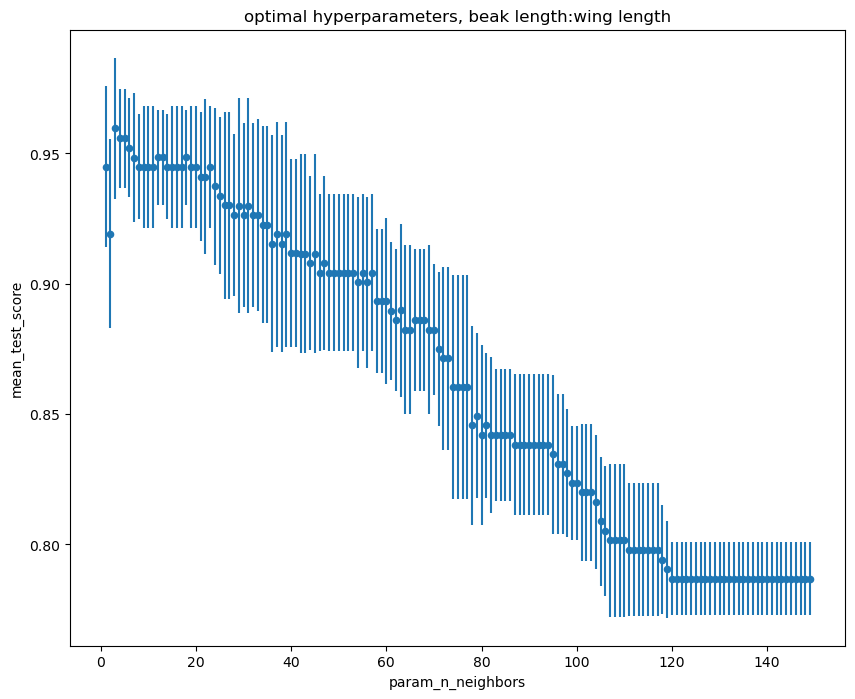

In [11]:
hyperparameters_blwl = {
    "n_neighbors" : range(1, 150),
}
blwl_model_cv = GridSearchCV(KNeighborsClassifier(), hyperparameters_blwl)
blwl_model_cv.fit(train_X_blwl, train_y)

cv_blwl = pd.DataFrame(blwl_model_cv.cv_results_)
cv_blwl.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", figsize=(10,8))
plt.title("optimal hyperparameters, beak length:wing length")

As the standard deviations around each n value are large, we should check further:

In [12]:
#create table to show ranking of n_neighbours as well as visualisation
clf_blwl = GridSearchCV(KNeighborsClassifier(), hyperparameters_blwl).fit(train_X_blwl, train_y)

#create df from GridSearchCV results
blwl_results = DataFrame(clf_blwl.cv_results_)

#sort based on rank_test_score
blwl_results = blwl_results.sort_values(["rank_test_score", "mean_test_score"])

print(blwl_results.head()[["param_n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]])

   param_n_neighbors  mean_test_score  std_test_score  rank_test_score
2                  3         0.959529        0.027164                1
3                  4         0.955758        0.019032                2
4                  5         0.955758        0.019032                2
5                  6         0.952121        0.018916                4
11                12         0.948418        0.018231                5


In [13]:
best_n_blwl = cv_blwl.loc[cv_blwl['mean_test_score'].idxmax()]['param_n_neighbors']
best_n_blwl

3

We use this best value in our model.

In [14]:
blwl_model = KNeighborsClassifier(n_neighbors=best_n_blwl)
blwl_model.fit(train_X_blwl, train_y)

KNeighborsClassifier(n_neighbors=3)

Text(0.5, 1.0, 'Model Score: 0.9558823529411765')

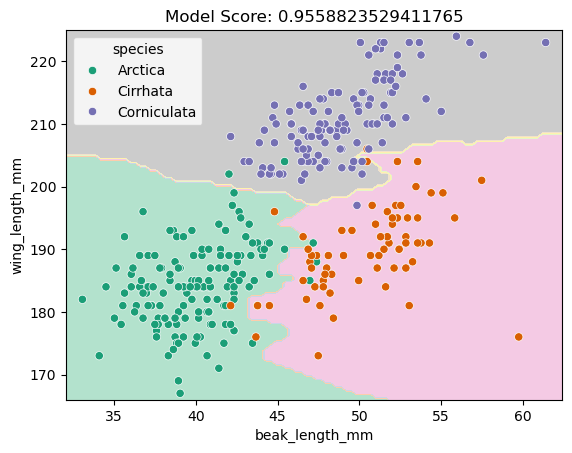

In [15]:


#create Decision Boundary Display
display = DecisionBoundaryDisplay.from_estimator(blwl_model, X_blwl, cmap="Pastel2")

#create scatter on boundary display
sns.scatterplot(data=X_blwl, x="beak_length_mm", y="wing_length_mm", hue=y, palette="Dark2")
#annotate the plot with the model score
plt.title(f"Model Score: {blwl_model.score(test_X_blwl, test_y)}")



In [16]:
#create a dataset of values to test the model prediction
blwl_X_values = pd.DataFrame({
    "beak_length_mm": np.random.uniform(low=30, high = 60, size=(5)),
    "wing_length_mm": np.random.uniform(low=170, high = 220, size=(5)),
})

#predict the species based on the X values 
blwl_predictions = blwl_model.predict(blwl_X_values)

#append to X values dataframe
blwl_X_values["species prediction"] = blwl_predictions

blwl_X_values


,beak_length_mm,wing_length_mm,species prediction
0,45.549262,211.559814,Corniculata
1,46.077596,173.834823,Cirrhata
2,32.966895,191.845346,Arctica
3,33.517681,195.930708,Arctica
4,45.755801,207.423411,Corniculata


The creation of a dataframe generating random beak length and wing length amounts, and their predicted species shows that this model is sufficient; a 95.5% accuracy is high. Very few instances of species outside of their boundaries.

### Beak length (mm) vs. beak depth (mm) classifier

In [17]:
X_bdbl = puffins_new[["beak_depth_mm", "beak_length_mm"]]
y= puffins_new["species"]

y = y.astype("category")

In [18]:
train_X_bdbl, test_X_bdbl, train_y, test_y = train_test_split(X_bdbl, y, test_size=0.2, random_state=42)

We can optimise the model effectiveness by determining the optimal number of neighbours.

Text(0.5, 1.0, 'optimal hyperparameters, beak depth:beak length')

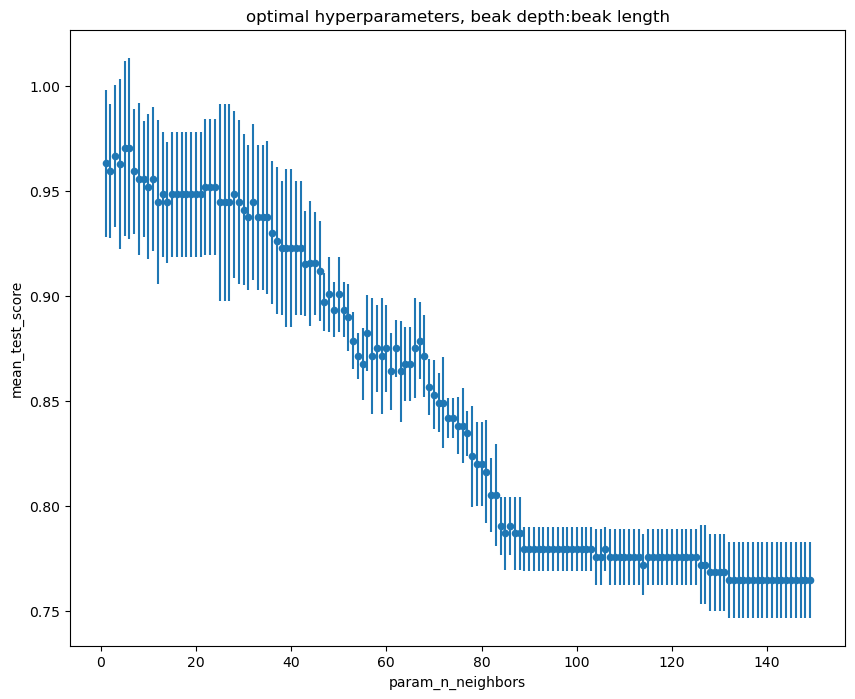

In [19]:
#set hyperparameters
hyperparameters_bdbl = {
    "n_neighbors" : range(1, 150),
}
bdbl_model_cv = GridSearchCV(KNeighborsClassifier(), hyperparameters_bdbl)
bdbl_model_cv.fit(train_X_bdbl, train_y)

#visualise score by number of neighbours
cv_bdbl = pd.DataFrame(bdbl_model_cv.cv_results_)
cv_bdbl.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", figsize=(10,8))
plt.title("optimal hyperparameters, beak depth:beak length")


In [20]:
#create table to show ranking of n_neighbours as well as visualisation
clf_bdbl = GridSearchCV(KNeighborsClassifier(), hyperparameters_bdbl).fit(train_X_bdbl, train_y)

#create df from GridSearchCV results
bdbl_results = DataFrame(clf_bdbl.cv_results_)

#sort based on rank_test_score
bdbl_results = bdbl_results.sort_values(["rank_test_score", "mean_test_score"])

print(bdbl_results.head()[["param_n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]])

  param_n_neighbors  mean_test_score  std_test_score  rank_test_score
4                 5         0.970370        0.041574                1
5                 6         0.970370        0.043192                2
2                 3         0.966667        0.033945                3
0                 1         0.963165        0.035032                4
3                 4         0.962963        0.040572                5


In [21]:
#determine the best number of neighbours for this classifier
best_n_bdbl = cv_bdbl.loc[cv_bdbl['mean_test_score'].idxmax()]['param_n_neighbors']
best_n_bdbl

5

From this visualisation and above, we can determine that the optimal number of neighbours for this model is 5. We can continue to create this model with this optimal fit.

In [22]:
bdbl_model = KNeighborsClassifier(n_neighbors=best_n_bdbl)
bdbl_model.fit(train_X_bdbl, train_y)

KNeighborsClassifier()

Text(0.5, 1.0, 'Model Score: 0.9411764705882353')

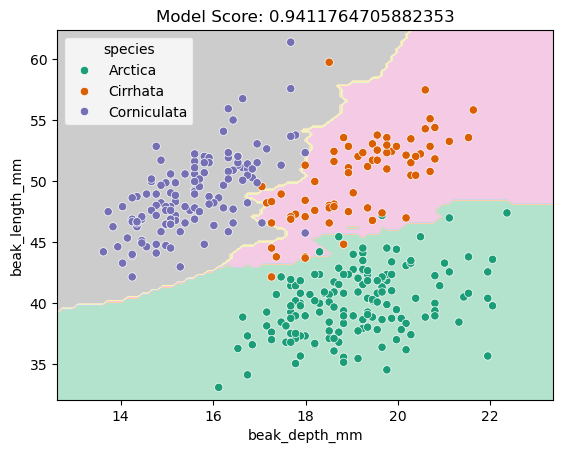

In [23]:
#create plot 
DecisionBoundaryDisplay.from_estimator(bdbl_model, X_bdbl, cmap="Pastel2")
sns.scatterplot(data=X_bdbl, x="beak_depth_mm", y="beak_length_mm", hue=y, palette="Dark2")
plt.title(f"Model Score: {bdbl_model.score(test_X_bdbl, test_y)}")

In [24]:
#create a dataset of values to test the model prediction
bdbl_X_values = pd.DataFrame({
    "beak_depth_mm": np.random.uniform(low=12, high = 25, size=(5)),
    "beak_length_mm": np.random.uniform(low=30, high = 60, size=(5)),
})
#create limited prediction dataframe with X values 
bdbl_predictions = bdbl_model.predict(bdbl_X_values)

bdbl_X_values["species prediction"] = bdbl_predictions

bdbl_X_values

,beak_depth_mm,beak_length_mm,species prediction
0,24.252257,44.660090,Arctica
1,19.812591,51.213510,Cirrhata
2,22.136187,52.061141,Cirrhata
3,16.908977,37.467458,Arctica
4,16.748113,42.020692,Arctica


This classifier is also seemingly predicting the species effectively; a 94% accuracy score is high. Visually there are very few instances of species outside of their boundary.

### Body mass (kg) vs. beak length (mm) classifier

In [25]:
#split X values 
X_bmbl = puffins_new[["body_mass_kg", "beak_length_mm"]]
y= puffins_new["species"]

y = y.astype("category")


In [26]:
train_X_bmbl, test_X_bmbl, train_y, test_y = train_test_split(X_bmbl, y, test_size=0.2, random_state=42)


Text(0.5, 1.0, 'optimal hyperparameters, body mass:beak length')

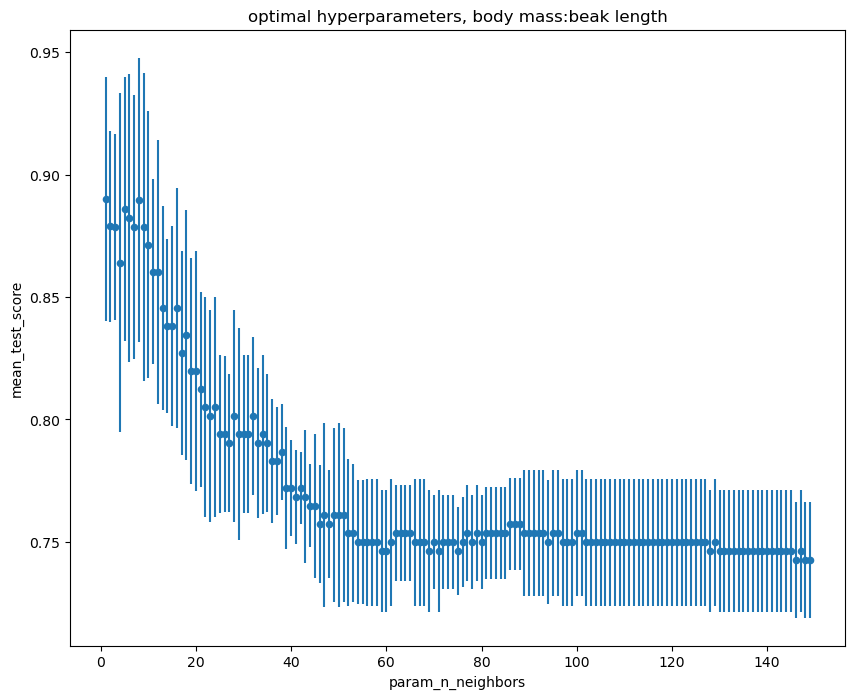

In [27]:
#set hyperparameters
hyperparameters_bmbl = {
    "n_neighbors" : range(1, 150),
}
bmbl_model_cv = GridSearchCV(KNeighborsClassifier(), hyperparameters_bmbl)
bmbl_model_cv.fit(train_X_bmbl, train_y)

#visualise score by number of neighbours
cv_bmbl = pd.DataFrame(bmbl_model_cv.cv_results_)
cv_bmbl.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", figsize=(10,8))
plt.title("optimal hyperparameters, body mass:beak length")

As the standard deviations around each k value are large, we should check further:

In [28]:
#create table to show ranking of n_neighbours as well as visualisation
clf_bmbl = GridSearchCV(KNeighborsClassifier(), hyperparameters_bmbl).fit(train_X_bmbl, train_y)

#create df from GridSearchCV results
bmbl_results = DataFrame(clf_bmbl.cv_results_)

#sort based on rank_test_score
bmbl_results = bmbl_results.sort_values(["rank_test_score", "mean_test_score"])

print(bmbl_results.head()[["param_n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]])

  param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                 1         0.890034        0.049713                1
7                 8         0.889630        0.058167                2
4                 5         0.885993        0.053833                3
5                 6         0.882290        0.058993                4
1                 2         0.878855        0.038953                5


In [29]:
best_n_bmbl = cv_bmbl.loc[cv_bmbl["mean_test_score"].idxmax()]["param_n_neighbors"]
best_n_bmbl

1

As our best n_neighbours remains consistent, we can continue to fit the model with k=1.


In [30]:
bmbl_model = KNeighborsClassifier(n_neighbors=best_n_bmbl)
bmbl_model.fit(train_X_bmbl, train_y)

KNeighborsClassifier(n_neighbors=1)

Text(0.5, 1.0, 'Model Score: 0.8676470588235294')

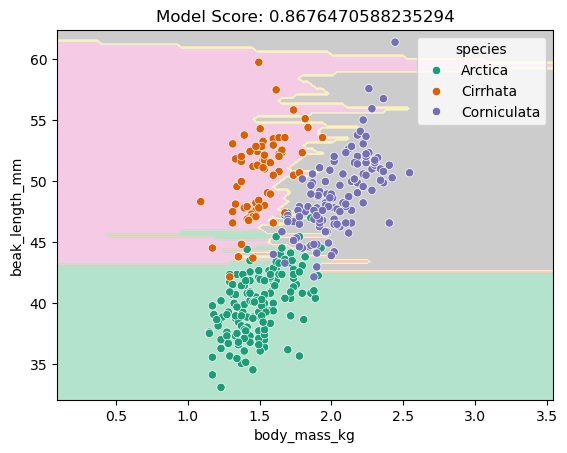

In [31]:
#create plot
DecisionBoundaryDisplay.from_estimator(bmbl_model, X_bmbl, cmap="Pastel2")
sns.scatterplot(data=X_bmbl, x="body_mass_kg", y="beak_length_mm", hue=y, palette="Dark2")
plt.title(f"Model Score: {bmbl_model.score(test_X_bmbl, test_y)}")

In [32]:

#create a dataset of values to test the model prediction
bmbl_X_values = pd.DataFrame({
    "body_mass_kg": np.random.uniform(low=0.5, high = 3, size=(5)),
    "beak_length_mm": np.random.uniform(low=30, high = 60, size=(5)),
})

bmbl_predictions = bmbl_model.predict(bmbl_X_values)

bmbl_X_values["species prediction"] = bmbl_predictions

bmbl_X_values



,body_mass_kg,beak_length_mm,species prediction
0,0.896659,46.802872,Cirrhata
1,1.469719,57.333466,Cirrhata
2,2.856652,48.000595,Corniculata
3,0.876576,40.393645,Arctica
4,2.799895,42.373148,Arctica


From the points in the decision bounday display and the dataset predictions, this model is alright, albeit scores lower than the previous models. Visually we could suggest Cirrhata would be slightly harder to predict, which would be in keeping with the bias due to their smaller sample size.

### Model with all 4 variables and PCA

Next we create a classifier with all 4 puffin data columns and a PCA, to determine the best fitting model of the components.

In [33]:
#Separating features (X) and target variable (y)
X_all = puffins_new[["wing_length_mm", "beak_length_mm", "beak_depth_mm", "body_mass_kg"]]
y_all = puffins_new["species"]
#Converting the target variable y to categorical type
y_all = y_all.astype("category")

X_all #the effector variables are separated into X 

,wing_length_mm,beak_length_mm,beak_depth_mm,body_mass_kg
0,181.0,39.243,18.304,1.384
1,189.0,44.084,19.240,1.717
2,184.0,40.376,19.344,1.717
3,187.0,37.904,19.240,1.414
4,177.0,37.595,18.720,1.273
...,...,...,...,...
339,207.0,44.805,15.808,1.879
340,202.0,46.659,14.352,1.697
341,224.0,55.929,16.328,2.283
342,223.0,50.058,16.640,2.343


In [34]:
train_X_all, test_X_all, train_y_all, test_y_all = train_test_split(X_all, y_all, random_state = 42)

The hyperparameters for the all variable model are visualised.

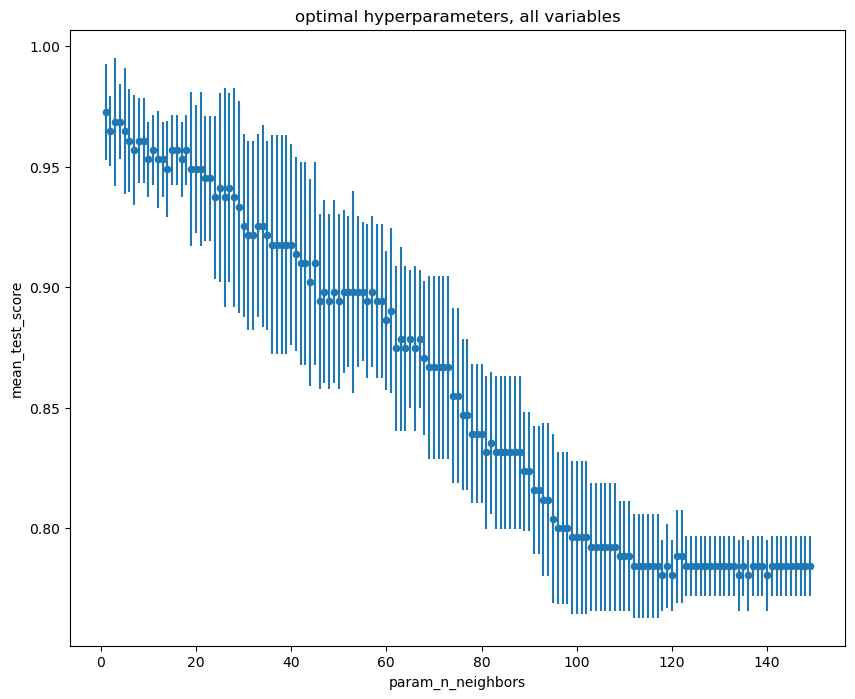

In [35]:
#create hyperparametesr
hyperparameters_all = {
    "n_neighbors" : range(1, 150),
}
all_model_cv = GridSearchCV(KNeighborsClassifier(), hyperparameters_all)
all_model_cv.fit(train_X_all, train_y_all)

#visualise score by number of neighbours
cv_all = pd.DataFrame(all_model_cv.cv_results_)
cv_all.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", figsize=(10,8))
plt.title("optimal hyperparameters, all variables")
plt.show()


In [36]:
best_n_all = cv_all.loc[cv_all["mean_test_score"].idxmax()]["param_n_neighbors"]
best_n_all

1

In the creation of our PCA, the data is also scaled to standardise the features within the model, in order to reduce bias. Scaling is useful in the steps prior to PCA as it ensures each feature has equal contribution to the principal components. The decision was made not to scale the pairwise classifiers, as the scale has less effect on the interpretation of the pairwise predictions. 

In [37]:
#Pipeline to scale 
scaled_knn_all = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)
scaled_knn_all

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [38]:
scaled_knn_all.fit(test_X_all, test_y_all)
print(scaled_knn_all.score(test_X_all, test_y_all))

0.9764705882352941


As shown by the improved score, scaling the data improves the model score of the classifer.

In [39]:
#create PCA from scaled test data
scaled_pca_knn_all = GridSearchCV(
    make_pipeline(
    StandardScaler(),
    PCA(), 
    KNeighborsClassifier()
    ),
    {"pca__n_components": range(1,5)
    },
)
scaled_pca_knn_all

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'pca__n_components': range(1, 5)})

In [40]:
scaled_pca_knn_all.fit(train_X_all, train_y_all)
scaled_pca_knn_all.score(test_X_all, test_y_all)

0.9882352941176471

In [41]:
pipeline = make_pipeline(
    StandardScaler(),
    PCA(),
    KNeighborsClassifier()
)

#Define the parameter grid
param_grid = {
    "pca__n_components": range(1, 5),
}

#Create GridSearchCV object
scaled_pca_knn_cv_all = GridSearchCV(pipeline, param_grid)

#Fit GridSearchCV to training data
scaled_pca_knn_cv_all.fit(train_X_all, train_y_all)  

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'pca__n_components': range(1, 5)})

In [42]:
#Accessing the best hyperparameters
best_hyperparameters = scaled_pca_knn_cv_all.best_params_
print("Best Hyperparameters:", best_hyperparameters)

#Accessing the best estimator
best_estimator = scaled_pca_knn_cv_all.best_estimator_
print("Best Estimator:", best_estimator)


Best Hyperparameters: {'pca__n_components': 3}
Best Estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('kneighborsclassifier', KNeighborsClassifier())])


The output of the above cell shows us that for this classification, reducing the dimensionality from 4 to 3 components provides the optimal representation. 

The best estimator tells us our final model achieving the highest performance will be scaled; the features are all standardised and therefore contribute equally to the model, resulting in higher performance. With both the scaling and reduction in dimensions by PCA, the use of KNN in this classifier means that the patterns in the data can be effectively used for accurate predictions.

In [43]:
scaled_pca_knn_cv_all.fit(train_X_all, train_y_all)
print(scaled_pca_knn_cv_all.score(test_X_all, test_y_all))

0.9882352941176471


With a high model score of 0.988, we can further analyse the precision of our model by visualising it using confusion matrices.

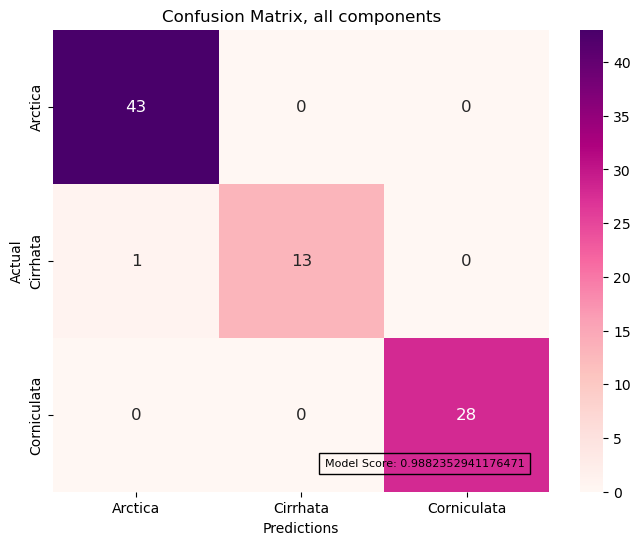

In [44]:
# Create predictions from the optimal model using test data
predictions_all = scaled_pca_knn_cv_all.predict(test_X_all)


# Initialize the confusion matrix 
conf_matrix_all = confusion_matrix(test_y_all, predictions_all)
#print(conf_matrix_all)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_all, annot=True, cmap="RdPu", fmt="d", xticklabels=scaled_pca_knn_cv_all.classes_, yticklabels=scaled_pca_knn_cv_all.classes_, annot_kws={"fontsize": 12})
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Confusion Matrix, all components")
plt.text(0.95, 0.05, f"Model Score: {scaled_pca_knn_cv_all.score(test_X_all, test_y_all)}", ha="right", va="bottom", transform=plt.gca().transAxes, fontsize=8, bbox=dict(facecolor="none"))

plt.show()




Plotting a confusion matrix shows us how many of the predictions were true to their expected species. This confusion matrix shows:
- 43 correct predictions of the Arctica species
- 13 correct predictions of the Cirrhata species
- 28 correct predictions of the Corniculata species
- 1 incorrect prediction of Cirrhata as Arctica as the only incorrect prediction

This shows a high success rate of this model, reflecting the 98.8% model score. We can compare this to our pairwise models that achieved lower scores:




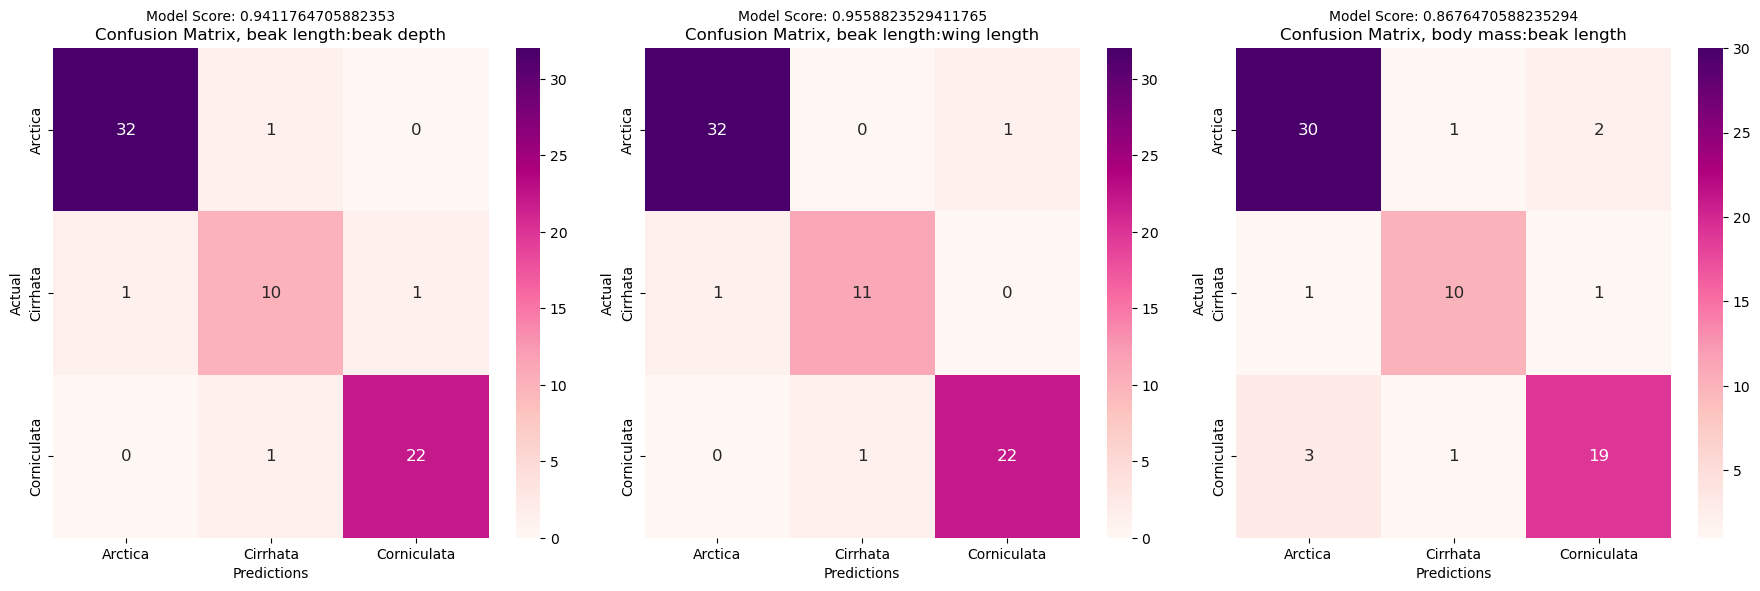

In [45]:
#initialise matrices
bdbl_predictions_matrix = bdbl_model.predict(test_X_bdbl)
conf_matrix_bdbl = confusion_matrix(test_y, bdbl_predictions_matrix)

blwl_predictions_matrix = blwl_model.predict(test_X_blwl)
conf_matrix_blwl = confusion_matrix(test_y, blwl_predictions_matrix)

bmbl_predictions_matrix = bmbl_model.predict(test_X_bmbl)
conf_matrix_bmbl = confusion_matrix(test_y, bmbl_predictions_matrix)


#initialise figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#generate and plot confusion matrix for model 1 (beak length: beak depth)
sns.heatmap(conf_matrix_bdbl, annot=True, cmap="RdPu", fmt="d", xticklabels=bdbl_model.classes_, yticklabels=bdbl_model.classes_, annot_kws={"fontsize": 12}, ax=axes[0])
axes[0].set_xlabel("Predictions")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix, beak length:beak depth")
axes[0].text(0.5, 1.05, f"Model Score: {bdbl_model.score(test_X_bdbl, test_y)}", transform=axes[0].transAxes, fontsize=10, ha="center", va="bottom")

#generate and plot confusion matrix for model 2 (beak length: wing length)
sns.heatmap(conf_matrix_blwl, annot=True, cmap="RdPu", fmt="d", xticklabels=blwl_model.classes_, yticklabels=blwl_model.classes_, annot_kws={"fontsize": 12}, ax=axes[1])
axes[1].set_xlabel("Predictions")
axes[1].set_ylabel("Actual")
axes[1].set_title("Confusion Matrix, beak length:wing length")
axes[1].text(0.5, 1.05, f"Model Score: {blwl_model.score(test_X_blwl, test_y)}", transform=axes[1].transAxes, fontsize=10, ha="center", va="bottom")

#generate and plot confusion matrix for model 3 (body mass: beak length)
sns.heatmap(conf_matrix_bmbl, annot=True, cmap="RdPu", fmt="d", xticklabels=bmbl_model.classes_, yticklabels=bmbl_model.classes_, annot_kws={"fontsize": 12}, ax=axes[2])
axes[2].set_xlabel("Predictions")
axes[2].set_ylabel("Actual")
axes[2].set_title("Confusion Matrix, body mass:beak length")
axes[2].text(0.5, 1.05, f"Model Score: {bmbl_model.score(test_X_bmbl, test_y)}", transform=axes[2].transAxes, fontsize=10, ha="center", va="bottom")


plt.tight_layout()
plt.show()



When we compare each of the pairwise classifiers, we can see a negative correlation between model score and number of incorrect predictions. Our final model, ` scaled_pca_knn_cv_all ` has the highest score and most accurate predictions compared to the pairwise classifiers. Additionally, when seeing these scores together, we could hypothesise "body_mass_kg" to be the least important feature - we can test this.

As we know that 3 components creates the best model score of 9.88, we can decide which 3 of the 4 variables are included in the optimal model. 

9.88 is very high, and this model is a good fit.

In [46]:
best_pca = scaled_pca_knn_cv_all.best_estimator_["pca"]

#get the explained variance ratio for each component
explained_variance_ratio = best_pca.explained_variance_ratio_

#sort the components by their contribution to variance
sorted_indices = np.argsort(explained_variance_ratio)[::-1]

#select the indices of the top 3 components
top_3_indices = sorted_indices[:3]

#get the top 3 components
top_3_components = best_pca.components_[top_3_indices]

#print top 3 components
print("Top 3 components:")
for i, component in enumerate(top_3_components):
    print(f"Component {i+1}: {component}")


Top 3 components:
Component 1: [ 0.57650994  0.44815883 -0.40507546  0.55018527]
Component 2: [-4.13293917e-04  6.27906316e-01  7.75952241e-01  6.02628201e-02]
Component 3: [-0.22627755  0.61823687 -0.45376036 -0.60056905]


We can visualise this with a heatmap:

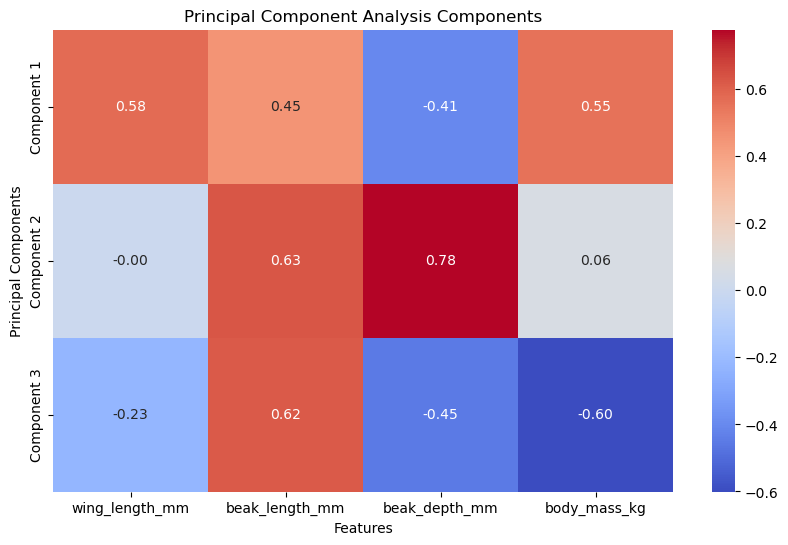

In [47]:
#Get the feature names
feature_names = X_all.columns

# Create a df to store the components and their corresponding feature names
components_df = pd.DataFrame(best_pca.components_, columns=feature_names)

#Plot a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(components_df, cmap="coolwarm", annot=True, fmt=".2f", yticklabels=["Component 1", "Component 2", "Component 3"])
plt.title("Principal Component Analysis Components")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.show()

In this heatmap:

Each row represents a principal component.
Each column represents a feature from the original dataset.
The values in the heatmap represent the weights (coefficients) of each feature in each principal component.
Positive values indicate that the feature positively contributes to the principal component, while negative values indicate a negative contribution. 

From this, as well as the lower score produced by our body_mass model, we can determine that the best features for our model are wing_length_mm, beak_length_mm and beak_depth_mm.

<br>

### Classification Analysis

The steps taken in this classification analysis have led to the resulting classification created by scaling, principal component analysis (PCA), k-nearest neighbours (KNN), and cross validation (CV) of the four features to predict puffin species.

The data was cleaned including creating uniformity between the units of measurement and removal of NA values. No outliers were detected in the data description. 
The visualisation of the species in the six paired variable options returned three pairings showing species distinction, which were each classified.

To visualise the classifiers, a KNN algorithm was used over other methods such as logistic regression, as our data is non-linear. In each step, the optimal n_neighbours was determined to produce the best fitting classifier at each stage. The visualisations of n_neighbours aided in selecting the optimal k value to improve the robustness of the data. The decision boundary visualisations showed how well the predicted species fell into their actual values. Confusion matrices also helped visualise the successful predictions by each model, and made comparing all four classifiers simple.

The PCA completed on all four of the variables returned three components as the optimal amount for this classifier. While pairwise KNN classifications were run on each of the pairs showing distinction between the three species, the model scores and heatmaps produced showed that the model produced via PCA was more effective in predicting species. The coefficients of each feature were plotted, determining body_mass_kg to be dropped as a feature from the optimal classifier, as it did not have as high a contribution to any component.

Further model improvement could consist of further optimisation of the hyperparameters, more cross-validation techniques, and class-weighting, as there could be class-weighting bias against Cirrhata. 

Overall, a well-fitting model with a score of 0.988 has been chosen to predict puffin species from these factors.